# Imports

In [15]:
from time import time
import datetime
import pandas as pd 
import numpy as np
import tensorflow as tf
import keras
from tqdm import tqdm_notebook as tqdm
#!pip install -q git+https://github.com/oanda/oandapy.git
import oandapy as opy
from datetime import datetime as dt

#!pip install statsmodels
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt
import numpy as np
from tpot import TPOTClassifier, TPOTRegressor
from keras.layers.core import Dense, Activation, Dropout
from keras.layers import Flatten
from keras.layers.recurrent import LSTM
from keras.models import Sequential
import math
from sklearn.metrics import roc_curve
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
import keras.layers as kl
from keras.callbacks import TensorBoard, EarlyStopping
%matplotlib notebook

# Data

In [2]:
oanda = opy.API(environment='live')

In [3]:
# Input for downloading data using Oanda API
d1 = '2008-01-01'
d2 = str(dt.now())[:10]
instrument = 'USD_JPY'

In [4]:
# Download data in chucks
dates = pd.date_range(start=d1, end=d2, freq='D')
df = pd.DataFrame()

print('Se van a descargar {} días'.format(len(dates)))
print('Descargando:')
pbar = tqdm(total=len(dates) -1)
for i in range(0, len(dates) -1):
    d1 = str(dates[i]).replace(' ', 'T')
    d2 = str(dates[i+1]).replace(' ', 'T')
     
    try:
        data = oanda.get_history(instrument=instrument, start=d1, end=d2, granularity='D')
        df = df.append(pd.DataFrame(data['candles']))
        pbar.update(1)
    except:
        pass
pbar.close()
date = pd.DatetimeIndex(df['time'], tz='UTC')
df['date'] = date

Se van a descargar 3948 días
Descargando:


In [10]:
df.to_csv('USD_JPY_D.csv')

In [11]:
DF = df.copy()

In [5]:
DF = pd.read_csv('USD_JPY_D.csv', index_col=0)

In [6]:
df = DF.copy()

In [7]:
df.head()

,closeAsk,closeBid,complete,highAsk,highBid,lowAsk,lowBid,openAsk,openBid,time,volume,date
0,111.710,111.610,True,111.786,111.645,111.520,111.344,111.744,111.644,2007-12-31T22:00:00.000000Z,605,2007-12-31 22:00:00+00:00
1,109.665,109.645,True,112.185,112.085,109.213,109.197,111.705,111.605,2008-01-01T22:00:00.000000Z,27820,2008-01-01 22:00:00+00:00
0,109.665,109.645,True,112.185,112.085,109.213,109.197,111.705,111.605,2008-01-01T22:00:00.000000Z,27820,2008-01-01 22:00:00+00:00
1,109.337,109.317,True,109.768,109.748,108.251,108.235,109.670,109.650,2008-01-02T22:00:00.000000Z,35284,2008-01-02 22:00:00+00:00
0,109.337,109.317,True,109.768,109.748,108.251,108.235,109.670,109.650,2008-01-02T22:00:00.000000Z,35284,2008-01-02 22:00:00+00:00


In [8]:
# quitamos los repetidos (Oanda trae 2 veces lo de cada día (?))
df.drop(0, inplace=True)

In [9]:
df.head(10)

,closeAsk,closeBid,complete,highAsk,highBid,lowAsk,lowBid,openAsk,openBid,time,volume,date
1,109.665,109.645,True,112.185,112.085,109.213,109.197,111.705,111.605,2008-01-01T22:00:00.000000Z,27820,2008-01-01 22:00:00+00:00
1,109.337,109.317,True,109.768,109.748,108.251,108.235,109.670,109.650,2008-01-02T22:00:00.000000Z,35284,2008-01-02 22:00:00+00:00
1,108.659,108.559,True,109.602,109.582,107.912,107.896,109.337,109.317,2008-01-03T22:00:00.000000Z,37154,2008-01-03 22:00:00+00:00
1,109.190,109.170,True,109.745,109.729,108.562,108.462,108.562,108.462,2008-01-06T22:00:00.000000Z,34891,2008-01-06 22:00:00+00:00
1,108.905,108.885,True,109.842,109.826,108.871,108.855,109.185,109.165,2008-01-07T22:00:00.000000Z,30222,2008-01-07 22:00:00+00:00
1,110.050,110.030,True,110.143,110.123,108.807,108.787,108.907,108.887,2008-01-08T22:00:00.000000Z,40933,2008-01-08 22:00:00+00:00
1,109.351,109.331,True,110.113,110.093,109.127,109.107,110.043,110.023,2008-01-09T22:00:00.000000Z,42076,2008-01-09 22:00:00+00:00
1,108.903,108.803,True,109.718,109.700,108.647,108.629,109.352,109.332,2008-01-10T22:00:00.000000Z,39871,2008-01-10 22:00:00+00:00
1,108.170,108.152,True,109.015,108.915,107.388,107.372,108.680,108.580,2008-01-13T22:00:00.000000Z,28514,2008-01-13 22:00:00+00:00
1,106.791,106.771,True,108.365,108.345,106.630,106.610,108.170,108.152,2008-01-14T22:00:00.000000Z,36442,2008-01-14 22:00:00+00:00


In [10]:
df = df.drop(['complete', 'time'], axis=1)

In [11]:
df.drop(['date'],inplace=True, axis=1)

In [12]:
df.head(10)

,closeAsk,closeBid,highAsk,highBid,lowAsk,lowBid,openAsk,openBid,volume
1,109.665,109.645,112.185,112.085,109.213,109.197,111.705,111.605,27820
1,109.337,109.317,109.768,109.748,108.251,108.235,109.670,109.650,35284
1,108.659,108.559,109.602,109.582,107.912,107.896,109.337,109.317,37154
1,109.190,109.170,109.745,109.729,108.562,108.462,108.562,108.462,34891
1,108.905,108.885,109.842,109.826,108.871,108.855,109.185,109.165,30222
1,110.050,110.030,110.143,110.123,108.807,108.787,108.907,108.887,40933
1,109.351,109.331,110.113,110.093,109.127,109.107,110.043,110.023,42076
1,108.903,108.803,109.718,109.700,108.647,108.629,109.352,109.332,39871
1,108.170,108.152,109.015,108.915,107.388,107.372,108.680,108.580,28514
1,106.791,106.771,108.365,108.345,106.630,106.610,108.170,108.152,36442


In [18]:
def train_test(Data, response, time_series=False):
    """
    Regresa train y test sets con el 75% de los datos
    para entrenar y el 25% para probar el modelo
    
    Args:
        Data (DataFrame): Datos listos para el modelo
        response (str): Variable respuesta
        time_series (boolean): Si es serie de tiempo o no
    Returns:
        X_train (Array): conjunto de datos de entrenamiento (indep)
        X_test (Array): conjunto de datos de prueba (indep)
        y_train (Array): conjunto de datos de entrenamiento (dep)
        y_test (Array): conjunto de datos de prueba (dep)
        
    """
    
    Data1 = Data.copy()
    X = Data1.drop(response, 1)
    y = Data1[response]
    print('X Variables: ')
    print(X.columns)
    print('\nResponse:')
    print(response)
    
    if time_series:
        tscv = TimeSeriesSplit(n_splits=2)
        for train_index, test_index in tscv.split(X):
            X_train, X_test = X.values[train_index], X.values[test_index]
            y_train, y_test = y.values[train_index], y.values[test_index]
    
    else:
        X_train, X_test, y_train, y_test = train_test_split(X, y,random_state = 0)
        X_train = X_train.values
        X_test = X_test.values
        y_train = y_train.values
        y_test = y_test.values
    
    return X_train, X_test, y_train, y_test

def tpotclass(X_train, y_train):
    """
    Usando TPOT (Tree-Based Pipeline Optimization Tool), librería de AutoML,
    genera el "mejor" modelo de clasificación automáticamente
    Args:
        X_train (Array): conjunto de datos de entrenamiento (regresores)
        y_train (Array): conjunto de datos de entrenamiento (objetivo)
    Returns:
        tpotmod (modelo): Modelo de clasificación generado con TPOT
    """
    pipeline_optimizer = TPOTClassifier(generations=5,
                                        population_size=50,
                                        cv=5,
                                        random_state=42,
                                        verbosity=2,
                                        n_jobs=4)
    tpotmod = pipeline_optimizer.fit(X_train, y_train)

    return tpotmod

def tpotreg(X_train, y_train):
    """
    Usando TPOT (Tree-Based Pipeline Optimization Tool), librería de AutoML,
    genera el "mejor" modelo de regresión automáticamente
    Args:
        X_train (Array): conjunto de datos de entrenamiento (regresores)
        y_train (Array): conjunto de datos de entrenamiento (objetivo)
    Returns:
        tpotmod (modelo): Modelo de regresión generado con TPOT
    """

    pipeline_optimizer = TPOTRegressor(generations=5,
                                       population_size=50,
                                       cv=5,
                                       random_state=42,
                                       verbosity=2,
                                       n_jobs=4)
    tpotmod = pipeline_optimizer.fit(X_train, y_train)

    return tpotmod

def logreg(X_train, y_train):
    """
    Calcula modelo de Regresión Logística
    Args:
        X_train (Array): conjunto de datos de entrenamiento (regresores)
        y_train (Array): conjunto de datos de entrenamiento (objetivo)
    Returns:
        logreg (modelo): Regresión Logística
    """
    try:
        # Si la matriz es singular va a dar error
        log = sm.Logit(y_train, X_train)
        logreg_model = log.fit()
    except Exception as e:
        # Intentamos con la matriz hessiana
        print(e)
        log = sm.Logit(y_train, X_train)
        logreg_model = log.fit(method='bfgs')

    return logreg_model

def linreg(X_train, y_train):
    """
    Calcula modelo de Regresión Lineal
    Args:
        X_train (Array): conjunto de datos de entrenamiento (regresores)
        y_train (Array): conjunto de datos de entrenamiento (objetivo)
    Returns:
        linreg_model (modelo): Regresión Lineal
    """
    linreg = sm.OLS(y_train, X_train)
    linreg_model = linreg.fit()

    return linreg_model

def simple_model(X_train, y_train, tpot=False):
    """
    Obtiene variable objetivo, decide si es de clasificación o regresión
    y regresa un modelo simple
    Args:
        X_train (Array): conjunto de datos de entrenamiento (regresores)
        y_train (Array): conjunto de datos de entrenamiento (objetivo)
        tpot (boolean): si queremos generar modelo con tpot
    Returns:
        model (modelo): Regresión Logística o Lineal dependiendo de la variable
                         objetivo
        tpotmod (modelo): Modelo de Regresión o Clasificación generado con TPOT
    """
    tpotm = None
    # Revisamos si es modelo de clasificación binaria
    if len(set(np.unique(y_train))) == 2:
        model = logreg(X_train, y_train)
        if tpot:
            toptm = tpotclass(X_train, y_train)
    elif len(set(np.unique(y_train))) > 2 and len(set(np.unique(y_train))) < 10:
        multilog = sm.MNLogit(y_train, X_train)
        model = multilog.fit()
        if tpot:
            tpotm = tpotclass(X_train, y_train)
    else:
        model = linreg(X_train, y_train)
        if tpot:
            tpotm = tpotreg(X_train, y_train)

    return model, tpotm


  
def rnn_reg(X_train, y_train, bs=64, epcs=100):
  
    model = Sequential()

    model.add(LSTM(1000, activation='tanh', return_sequences=True, input_shape=(1, X_train.shape[1]), recurrent_dropout=0.5))
    model.add(LSTM(100, activation='tanh', return_sequences=True, recurrent_activation = 'hard_sigmoid', recurrent_dropout=0.4))          
    model.add(LSTM(10, activation='tanh', recurrent_activation = 'hard_sigmoid', recurrent_dropout=0.2))
    model.add(Dense(activation="linear", units=1))

    model.compile(loss ="mean_squared_error" , optimizer = "adam", metrics = ["mean_squared_error", "accuracy"])
    X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
    
    tensorboard = TensorBoard(log_dir="logs/{}(batches {})".format(datetime.datetime.now(),bs), 
                              histogram_freq=0, 
                              batch_size=bs, 
                              write_graph=True, 
                              write_grads=False, 
                              write_images=False, 
                              update_freq='epoch')
    
    early_stopping = EarlyStopping(monitor='val_loss',
                                   min_delta=0,
                                   patience=5,
                                   verbose=1,
                                   mode='auto',
                                   restore_best_weights= True)
    
    model.fit(X_train, y_train, verbose=1, batch_size=bs, epochs=epcs, validation_split=0.25, callbacks=[tensorboard, early_stopping])
   
    return model

def rnn_class(X_train, y_train, bs=512, epcs=5):
    
    input_data = kl.Input(shape=(1, self.input_shape))
    lstm = kl.LSTM(5, input_shape=(1, self.input_shape), return_sequences=True, activity_regularizer=regularizers.l2(0.003),
                       recurrent_regularizer=regularizers.l2(0), dropout=0.2, recurrent_dropout=0.2)(input_data)
    perc = kl.Dense(5, activation="sigmoid", activity_regularizer=regularizers.l2(0.005))(lstm)
    lstm2 = kl.LSTM(2, activity_regularizer=regularizers.l2(0.01), recurrent_regularizer=regularizers.l2(0.001),
                        dropout=0.2, recurrent_dropout=0.2)(perc)
    out = kl.Dense(1, activation="sigmoid", activity_regularizer=regularizers.l2(0.001))(lstm2)

    model = Model(input_data, out)
    model.compile(optimizer="adam", loss="mean_squared_error", metrics=["mse"])

    X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
    
    tensorboard = TensorBoard(log_dir="logs/{}".format(time()))
    
    model.fit(X_train, y_train, batch_size=bs, epochs=epcs, validation_split=0.05, callbacks=[tensorboard])
   
    return model

def model_precision(y_test, predictions, lim):
    """
    Args:
        y_test (array): Instancias de la variable dependiente
        predictions (array): Predicciones
        lim (float): Entre 0 y 1 que marca el límite de clasificación (arriba de lim se considera cierre)
    
    Returns:
        Accuracy (float): (tp+tn)/(tp+tn+fp+fn)
        Precision (float): tp/(tp+fp)
        Recall (float): tp/(tp+fn)
        F1_score (float): 2/(1/Precision+1/Recall) Media armónica entre Precision y Recall
        MCC (float): Matthiews Correlation Coefficient (tp*tn-fp*fn)/(math.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn)))
    
    """
          
    y_test.shape = [y_test.shape[0],1]
    predictions.shape = [predictions.shape[0],1]
    
    test = np.concatenate((y_test, predictions),axis=1)

    tp = ((test[:,0] == 1) & (test[:,1] >= lim)).sum()
    fp = ((test[:,0] == 0) & (test[:,1] >= lim)).sum()
    tn = ((test[:,0] == 0) & (test[:,1] < lim)).sum()
    fn = ((test[:,0] == 1) & (test[:,1] < lim)).sum()
    
    Accuracy = (tp+tn)/(tp+tn+fp+fn)
    Precision = tp/(tp+fp)
    Recall = tp/(tp+fn)
    F1_score = 2/(1/Precision+1/Recall)
    MCC = (tp*tn-fp*fn)/(math.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn)))
    

    res = pd.DataFrame(0, index=['Accuracy', 'Precision',
                                     'Recall', 'F1 Score',
                                     'MCC'], columns=['Score'])

    res.loc['Accuracy'] = 100*Accuracy
    res.loc['Precision'] = 100*Precision
    res.loc['Recall'] = 100*Recall
    res.loc['F1 Score'] = 100*F1_score
    res.loc['MCC'] = 100*MCC
    display(res)
    
    return Accuracy, Precision, Recall, F1_score, MCC

def bucket_scores(y_test, predictions):
    """
    Precision por cubeta de 10 en 10
    
    Args:
        y_test (array): Instancias de la variable dependiente
        predictions (array): Predicciones
    
    Returns:
        res (DataFrame): Positive rate por scores de 1 a 100 en cubetas de 10
    
    """
    scoresindex = ['0-10','10-20','20-30','30-40','40-50','50-60','60-70','70-80','80-90','90-100']
    scorescolumns = ['Total','Positives']
    res = pd.DataFrame(0, index=scoresindex, columns=scorescolumns)
    
    y_test.shape = [y_test.shape[0],1]
    predictions.shape = [predictions.shape[0],1]
    
    test = np.concatenate((y_test,predictions),axis=1)
    
    low = 0
    up = 0.1
    for i in scoresindex:
        res.loc[i]['Total'] = ((test[:,1] >= low) & (test[:,1] < up)).sum()
        res.loc[i]['Positives'] = ((test[:,1] >= low) & (test[:,1] < up) & (test[:,0] == 1)).sum()
        low += 0.1
        up += 0.1
    res['Positive Rate'] = res['Positives']/res['Total']*100  
    
    return res

# Price

## Future Close (price)

X Variables: 
Index(['closeAsk', 'highAsk', 'highBid', 'lowAsk', 'lowBid', 'openAsk',
       'openBid', 'volume'],
      dtype='object')

Response:
closeBid


<IPython.core.display.Javascript object>


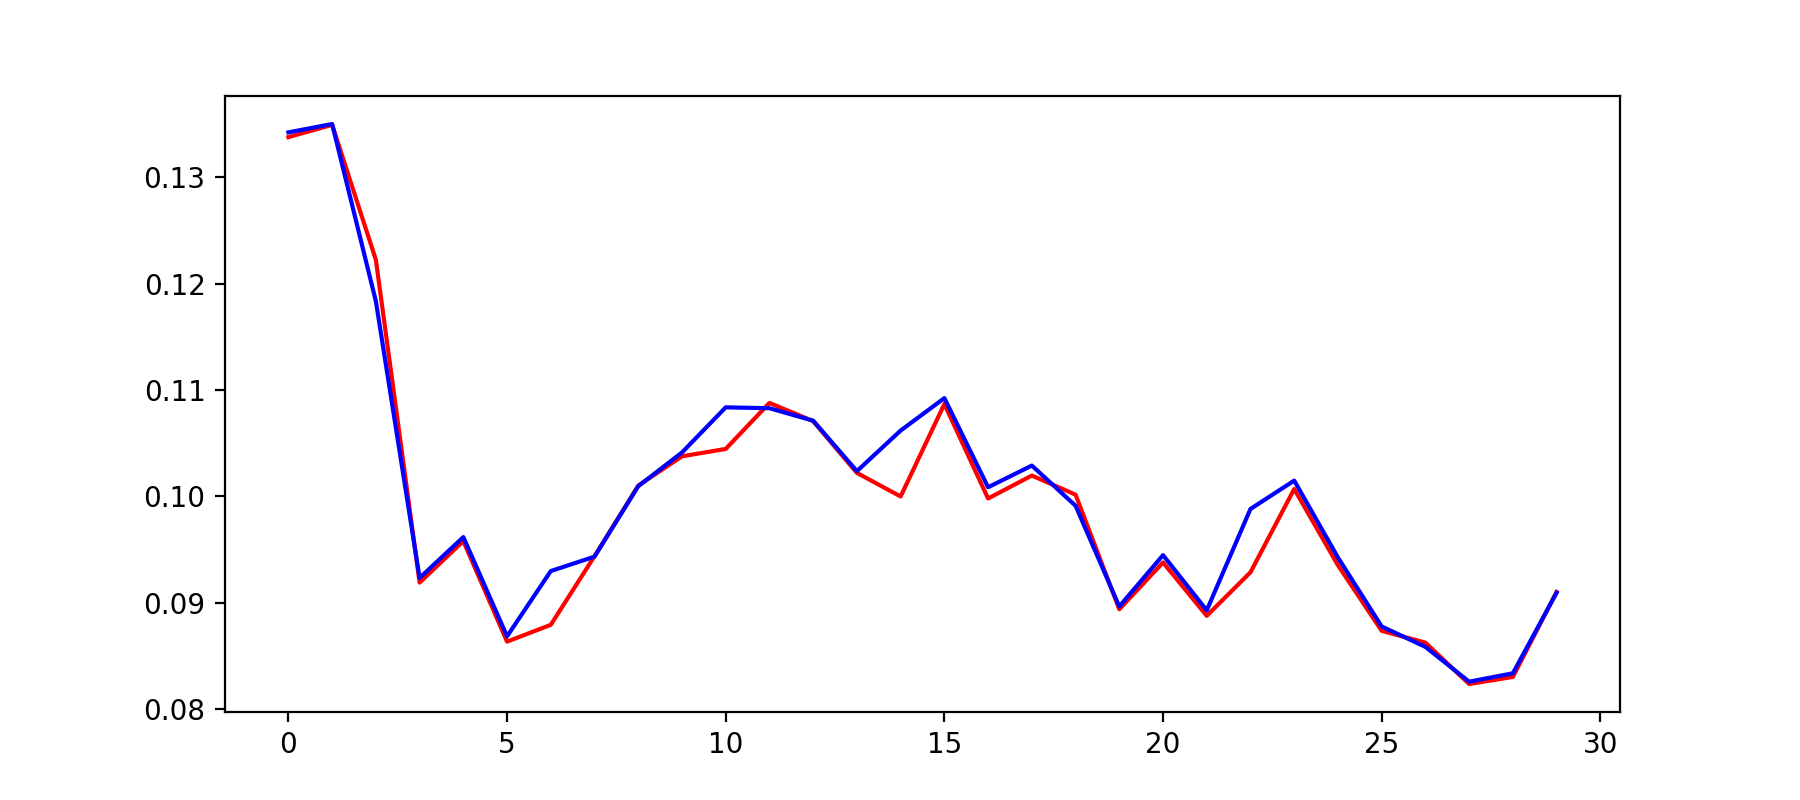

Train on 1411 samples, validate on 471 samples
Epoch 1/100
1411/1411 [==============================] - 5s 3ms/step - loss: 0.0321 - mean_squared_error: 0.0321 - acc: 0.0000e+00 - val_loss: 0.0093 - val_mean_squared_error: 0.0093 - val_acc: 0.0000e+00
Epoch 2/100
1411/1411 [==============================] - 3s 2ms/step - loss: 0.0042 - mean_squared_error: 0.0042 - acc: 0.0000e+00 - val_loss: 1.5734e-04 - val_mean_squared_error: 1.5734e-04 - val_acc: 0.0000e+00
Epoch 3/100
1411/1411 [==============================] - 3s 2ms/step - loss: 3.1770e-04 - mean_squared_error: 3.1770e-04 - acc: 0.0000e+00 - val_loss: 4.1189e-04 - val_mean_squared_error: 4.1189e-04 - val_acc: 0.0000e+00
Epoch 4/100
1411/1411 [==============================] - 3s 2ms/step - loss: 1.6575e-04 - mean_squared_error: 1.6575e-04 - acc: 0.0000e+00 - val_loss: 1.5901e-04 - val_mean_squared_error: 1.5901e-04 - val_acc: 0.0000e+00
Epoch 5/100
1411/1411 [==============================] - 3s 2ms/step - loss: 1.3909e-04 - mea

Epoch 38/100
1411/1411 [==============================] - 3s 2ms/step - loss: 3.9810e-05 - mean_squared_error: 3.9810e-05 - acc: 0.0000e+00 - val_loss: 5.7306e-05 - val_mean_squared_error: 5.7306e-05 - val_acc: 0.0000e+00
Epoch 39/100
1411/1411 [==============================] - 3s 2ms/step - loss: 4.0543e-05 - mean_squared_error: 4.0543e-05 - acc: 0.0000e+00 - val_loss: 5.6218e-05 - val_mean_squared_error: 5.6218e-05 - val_acc: 0.0000e+00
Epoch 40/100
1411/1411 [==============================] - 4s 2ms/step - loss: 3.8057e-05 - mean_squared_error: 3.8057e-05 - acc: 0.0000e+00 - val_loss: 5.4925e-05 - val_mean_squared_error: 5.4925e-05 - val_acc: 0.0000e+00
Epoch 41/100
1411/1411 [==============================] - 3s 2ms/step - loss: 3.7372e-05 - mean_squared_error: 3.7372e-05 - acc: 0.0000e+00 - val_loss: 5.4697e-05 - val_mean_squared_error: 5.4697e-05 - val_acc: 0.0000e+00
Epoch 42/100
1411/1411 [==============================] - 3s 2ms/step - loss: 3.7252e-05 - mean_squared_error: 3

Epoch 75/100
1411/1411 [==============================] - 2s 2ms/step - loss: 1.2965e-05 - mean_squared_error: 1.2965e-05 - acc: 0.0000e+00 - val_loss: 3.2293e-05 - val_mean_squared_error: 3.2293e-05 - val_acc: 0.0000e+00
Epoch 76/100
1411/1411 [==============================] - 3s 2ms/step - loss: 1.2256e-05 - mean_squared_error: 1.2256e-05 - acc: 0.0000e+00 - val_loss: 3.1579e-05 - val_mean_squared_error: 3.1579e-05 - val_acc: 0.0000e+00
Epoch 77/100
1411/1411 [==============================] - 3s 2ms/step - loss: 1.2567e-05 - mean_squared_error: 1.2567e-05 - acc: 0.0000e+00 - val_loss: 3.2142e-05 - val_mean_squared_error: 3.2142e-05 - val_acc: 0.0000e+00
Epoch 78/100
1411/1411 [==============================] - 3s 2ms/step - loss: 1.1807e-05 - mean_squared_error: 1.1807e-05 - acc: 0.0000e+00 - val_loss: 3.1885e-05 - val_mean_squared_error: 3.1885e-05 - val_acc: 0.0000e+00
Epoch 79/100
1411/1411 [==============================] - 3s 2ms/step - loss: 1.1205e-05 - mean_squared_error: 1

<IPython.core.display.Javascript object>


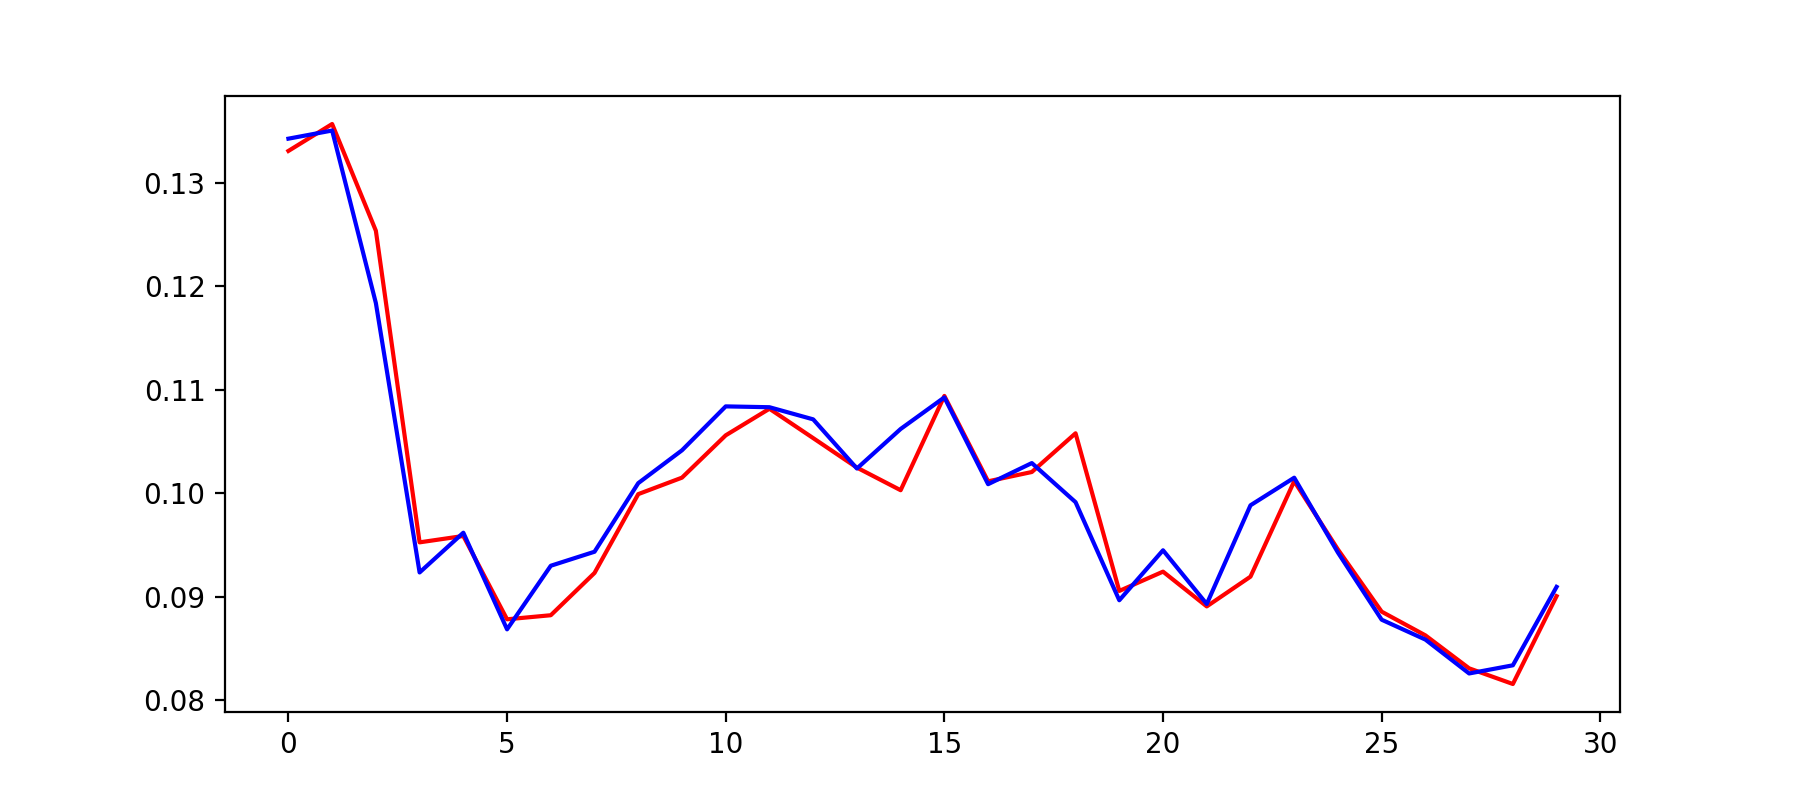

X_test.shape: (940, 1, 8)
X_test[0].shape: (1, 8)


In [19]:
df_fc = df.copy()

response = 'closeBid'

actual = 'openBid'

df_fc = (df_fc - df_fc.mean()) / (df_fc.max() - df_fc.min())

# esto lo hacemos para que se ajuste a que el close del día anterior será el open del día siguiente
df_fc[response] = df_fc[actual].shift(-1)

df_fc = df_fc.dropna()



X_train, X_test, y_train, y_test = train_test(df_fc, response, time_series=True)

### LINREG (price)

lr_fc = linreg(X_train, y_train)
#print(lr_fc.summary())
plt.figure(figsize=(9,4))
plt.plot(range(len(y_test[:30])),lr_fc.predict(X_test[:30]), color='r')
plt.plot(range(len(y_test[:30])),y_test[:30], color='b')
plt.show()

### RNN (price)

nn_fc = rnn_reg(X_train, y_train)

for feature in X_train[0]:
    print('Feature: {}'.format(feature))
print(y_train[0])

print(nn_fc.summary())
plt.figure(figsize=(9,4))
X_test = np.reshape(X_test, (X_test.shape[0],1, X_test.shape[1]))

print('X_test.shape: {}'.format(X_test.shape))
print('X_test[0].shape: {}'.format(X_test[0].shape))

plt.plot(range(len(y_test[:30])),nn_fc.predict(X_test[:30]), color='r')
plt.plot(range(len(y_test[:30])),y_test[:30], color='b')
plt.show()

In [44]:
nn_fc.predict([[[103.889,   103.947,   103.933,   103.594,   103.581,   103.682,   103.651, 46081.]]])

ValueError: Error when checking input: expected lstm_10_input to have 3 dimensions, but got array with shape (1, 8)

In [39]:
print('input: {}'.format(X_test[:30]))
print('predicción: {}'.format(nn_fc.predict(X_test[:30])))
print('true: {}'.format(y_test[:30]))

input: [[[  103.889   103.947   103.933   103.594   103.581   103.682   103.651
   46081.   ]]

 [[  103.949   104.124   104.11    103.821   103.807   103.894   103.866
   46799.   ]]

 [[  103.323   104.145   104.121   103.207   103.192   103.945   103.905
   60757.   ]]

 [[  101.821   103.13    103.115   101.556   101.542   103.109   103.08
   81596.   ]]

 [[  102.013   102.168   102.154   101.729   101.708   101.821   101.792
   58116.   ]]

 [[  101.547   102.146   102.131   101.339   101.318   102.014   101.982
   75548.   ]]

 [[  101.623   101.884   101.864   101.334   101.318   101.558   101.52
   73598.   ]]

 [[  101.935   102.001   101.988   101.508   101.495   101.864   101.824
   68343.   ]]

 [[  102.249   102.376   102.365   101.816   101.798   101.954   101.891
   54265.   ]]

 [[  102.401   102.477   102.462   101.875   101.855   102.257   102.219
   45462.   ]]

 [[  102.477   102.579   102.563   102.368   102.247   102.407   102.376
   15004.   ]]

 [[  102.647   1

In [32]:
X_train.shape

(1882, 8)

In [33]:
X_test.shape

(940, 1, 8)

In [19]:
for feature in X_train[1]:
    print('Feature: {}'.format(feature))
print('Response: {}'.format(y_train[1]))

Feature: 109.337
Feature: 109.768
Feature: 109.748
Feature: 108.251
Feature: 108.235
Feature: 109.67
Feature: 109.65
Feature: 35284.0
Response: 109.317


In [22]:
prueba = df_fc.copy()

In [24]:
prueba['closeBid'] = df_fc['openBid'].shift(-1)

In [28]:
df.head()

,closeAsk,closeBid,highAsk,highBid,lowAsk,lowBid,openAsk,openBid,volume
1,109.665,109.645,112.185,112.085,109.213,109.197,111.705,111.605,27820
1,109.337,109.317,109.768,109.748,108.251,108.235,109.670,109.650,35284
1,108.659,108.559,109.602,109.582,107.912,107.896,109.337,109.317,37154
1,109.190,109.170,109.745,109.729,108.562,108.462,108.562,108.462,34891
1,108.905,108.885,109.842,109.826,108.871,108.855,109.185,109.165,30222


In [27]:
df_fc.head()

,closeAsk,closeBid,highAsk,highBid,lowAsk,lowBid,openAsk,openBid,volume
1,109.665,109.650,112.185,112.085,109.213,109.197,111.705,111.605,27820
1,109.337,109.317,109.768,109.748,108.251,108.235,109.670,109.650,35284
1,108.659,108.462,109.602,109.582,107.912,107.896,109.337,109.317,37154
1,109.190,109.165,109.745,109.729,108.562,108.462,108.562,108.462,34891
1,108.905,108.887,109.842,109.826,108.871,108.855,109.185,109.165,30222


In [26]:
prueba.head()

,closeAsk,closeBid,highAsk,highBid,lowAsk,lowBid,openAsk,openBid,volume
1,109.665,109.650,112.185,112.085,109.213,109.197,111.705,111.605,27820
1,109.337,109.317,109.768,109.748,108.251,108.235,109.670,109.650,35284
1,108.659,108.462,109.602,109.582,107.912,107.896,109.337,109.317,37154
1,109.190,109.165,109.745,109.729,108.562,108.462,108.562,108.462,34891
1,108.905,108.887,109.842,109.826,108.871,108.855,109.185,109.165,30222


In [18]:
df_fc.head()

,closeAsk,closeBid,highAsk,highBid,lowAsk,lowBid,openAsk,openBid,volume
1,109.665,109.650,112.185,112.085,109.213,109.197,111.705,111.605,27820
1,109.337,109.317,109.768,109.748,108.251,108.235,109.670,109.650,35284
1,108.659,108.462,109.602,109.582,107.912,107.896,109.337,109.317,37154
1,109.190,109.165,109.745,109.729,108.562,108.462,108.562,108.462,34891
1,108.905,108.887,109.842,109.826,108.871,108.855,109.185,109.165,30222


In [56]:
print(nn_fc.summary())
plt.figure(figsize=(15,4))
X_test = np.reshape(X_test, (X_test.shape[0],1, X_test.shape[1]))

plt.plot(range(len(y_test)),nn_fc.predict(X_test), color='r')
plt.plot(range(len(y_test)),y_test, color='b')
plt.show()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_19 (LSTM)               (None, 1, 1000)           4036000   
_________________________________________________________________
lstm_20 (LSTM)               (None, 1, 100)            440400    
_________________________________________________________________
lstm_21 (LSTM)               (None, 10)                4440      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 11        
Total params: 4,480,851
Trainable params: 4,480,851
Non-trainable params: 0
_________________________________________________________________
None


<IPython.core.display.Javascript object>

ValueError: cannot reshape array of size 7520 into shape (940,1,1)

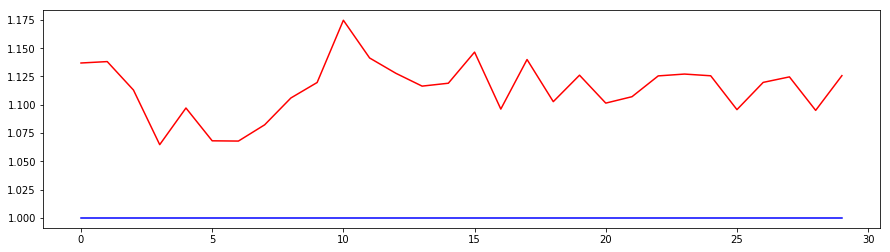

UnboundLocalError: local variable 'old_stack' referenced before assignment

In [50]:
## LINREG (price)

lr_fc = linreg(X_train, y_train)
#print(lr_fc.summary())
plt.figure(figsize=(15,4))
plt.plot(range(len(y_test[:30])),lr_fc.predict(X_test[:30]), color='r')
plt.plot(range(len(y_test[:30])),y_test[:30], color='b')
plt.show()

### RNN (price)

nn_fc = rnn_reg(X_train, y_train, bs=512, epcs=25)
print(nn_fc.summary())
plt.figure(figsize=(15,4))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
plt.plot(range(len(y_test[:30])),nn_fc.predict(X_test[:30]), color='r')
plt.plot(range(len(y_test[:30])),y_test[:30], color='b')
plt.show()

# Future High (price)

In [44]:
df_fh = df.copy()

response = 'Future diff highBid'
actual = 'diff highBid'
df_fh[response] = df_fh[actual].shift(-1)

df_fh = df_fh.dropna()

X_train, X_test, y_train, y_test = train_test(df_fh, response, time_series=True)

### LINREG (price)

lr_fh = linreg(X_train, y_train)
print(lr_fh.summary())
plt.figure(figsize=(15,4))
plt.plot(range(len(y_test[:30])),lr_fh.predict(X_test[:30]), color='r')
plt.plot(range(len(y_test[:30])),y_test[:30], color='b')
plt.show()

### RNN (price)

nn_fh = rnn_reg(X_train, y_train, bs=512, epcs=5)
print(nn_fh.summary())
plt.figure(figsize=(15,4))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
plt.plot(range(len(y_test[:30])),nn_fh.predict(X_test[:30]), color='r')
plt.plot(range(len(y_test[:30])),y_test[:30], color='b')
plt.show()

KeyError: 'diff highBid'

# Future Low (price)

In [45]:
df_fl = df.copy()

response = 'Future diff lowBid'

actual = 'diff lowBid'

df_fl[response] = df_fl[actual].shift(-1)

df_fl = df_fl.dropna()

X_train, X_test, y_train, y_test = train_test(df_fl, response, time_series=True)

### LINREG (price)

lr_fl = linreg(X_train, y_train)
print(lr_fl.summary())
plt.figure(figsize=(15,4))
plt.plot(range(len(y_test[:30])),lr_fl.predict(X_test[:30]), color='r')
plt.plot(range(len(y_test[:30])),y_test[:30], color='b')
plt.show()

### RNN (price)

nn_fl = rnn_reg(X_train, y_train, bs=512, epcs=5)
print(nn_fl.summary())
plt.figure(figsize=(15,4))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
plt.plot(range(len(y_test[:30])),nn_fl.predict(X_test[:30]), color='r')
plt.plot(range(len(y_test[:30])),y_test[:30], color='b')
plt.show()

KeyError: 'diff lowBid'

# Score

## Future Close (higher)

In [ ]:
df_fc = df.copy()
actual = 'diff closeBid'
response = 'Future close higher'
lim = 0.5
df_fc[response] = 0
df_fc.loc[df_fc[actual] >= 0, response] = 1
df_fc[response] = df_fc[response].shift(-1)
df_fc = df_fc.dropna()
X_train, X_test, y_train, y_test = train_test(df_fc, response, time_series=True)

### LOGREG
print('LOGREG')
lr_fc = logreg(X_train, y_train)
predictions = lr_fc.predict(X_test)
model_precision(y_test, predictions, lim)
bs = bucket_scores(y_test, predictions)
display(bs)

plt.figure(figsize=(17,18))
fpr, tpr, thresholds = roc_curve(y_test, predictions, pos_label=None, sample_weight=None, drop_intermediate=True)
plt.plot(fpr, tpr, 'r')
auc = np.trapz(tpr, fpr)
plt.axis([0,1,0,1])
plt.plot([0,1],[0,1], 'black')


### RNN 
print('RNN CLASS')
nn_fc = rnn_class(X_train, y_train, bs=512, epcs=20)
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
predictions = nn_fc.predict(X_test)
model_precision(y_test, predictions, lim)
bs = bucket_scores(y_test, predictions)
display(bs)

fpr, tpr, thresholds = roc_curve(y_test, predictions, pos_label=None, sample_weight=None, drop_intermediate=True)
plt.plot(fpr, tpr, 'b')

plt.show()

## Future High (higher)

In [47]:
df_fh = df.copy()
actual = 'highBid'
response = 'Future high higher'
lim = 0.5
df_fh[response] = 0
df_fh.loc[df_fh[actual] >= 0, response] = 1
df_fh[response] = df_fh[response].shift(-1)
df_fh = df_fh.dropna()
X_train, X_test, y_train, y_test = train_test(df_fh, response, time_series=True)

### LOGREG
print('LOGREG')
lr_fh = logreg(X_train, y_train)
predictions = lr_fh.predict(X_test)
model_precision(y_test, predictions, lim)
bs = bucket_scores(y_test, predictions)
display(bs)

plt.figure(figsize=(17,18))
fpr, tpr, thresholds = roc_curve(y_test, predictions, pos_label=None, sample_weight=None, drop_intermediate=True)
plt.plot(fpr, tpr, 'r')
auc = np.trapz(tpr, fpr)
plt.axis([0,1,0,1])
plt.plot([0,1],[0,1], 'black')

### RNN 
print('RNN CLASS')
nn_fh = rnn_class(X_train, y_train, bs=512, epcs=20)
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
predictions = nn_fh.predict(X_test)
model_precision(y_test, predictions, lim)
bs = bucket_scores(y_test, predictions)
display(bs)

fpr, tpr, thresholds = roc_curve(y_test, predictions, pos_label=None, sample_weight=None, drop_intermediate=True)
plt.plot(fpr, tpr, 'b')

plt.show()

X Variables: 
Index(['closeAsk', 'closeBid', 'highAsk', 'highBid', 'lowAsk', 'lowBid',
       'openAsk', 'openBid', 'volume'],
      dtype='object')

Response:
Future high higher
LOGREG
Perfect separation detected, results not available


PerfectSeparationError: Perfect separation detected, results not available

## Future Low (higher)

In [46]:
df_fl = df.copy()
actual = 'lowBid'
response = 'Future low higher'
lim = 0.5
df_fl[response] = 0
df_fl.loc[df_fl[actual] >= 0, response] = 1
df_fl[response] = df_fl[response].shift(-1)
df_fl = df_fl.dropna()
X_train, X_test, y_train, y_test = train_test(df_fl, response, time_series=True)

### LOGREG
print('LOGREG')
lr_fl = logreg(X_train, y_train)
predictions = lr_fl.predict(X_test)
model_precision(y_test, predictions, lim)
bs = bucket_scores(y_test, predictions)
display(bs)

plt.figure(figsize=(17,18))
fpr, tpr, thresholds = roc_curve(y_test, predictions, pos_label=None, sample_weight=None, drop_intermediate=True)
plt.plot(fpr, tpr, 'r')
auc = np.trapz(tpr, fpr)
plt.axis([0,1,0,1])
plt.plot([0,1],[0,1], 'black')

### RNN 
print('RNN CLASS')
nn_fl = rnn_class(X_train, y_train, bs=512, epcs=20)
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
predictions = nn_fl.predict(X_test)
model_precision(y_test, predictions, lim)
bs = bucket_scores(y_test, predictions)
display(bs)

fpr, tpr, thresholds = roc_curve(y_test, predictions, pos_label=None, sample_weight=None, drop_intermediate=True)
plt.plot(fpr, tpr, 'b')

plt.show()

X Variables: 
Index(['closeAsk', 'closeBid', 'highAsk', 'highBid', 'lowAsk', 'lowBid',
       'openAsk', 'openBid', 'volume'],
      dtype='object')

Response:
Future low higher
LOGREG
Perfect separation detected, results not available


PerfectSeparationError: Perfect separation detected, results not available

# Trading

In [48]:
response = oanda.get_history(instrument="USD_JPY", granularity='D', since='2018-08-23T01:00:00.00000Z')

('Connection aborted.', OSError("(60, 'ETIMEDOUT')",))


TypeError: the JSON object must be str, bytes or bytearray, not 'dict'

In [ ]:
pd.DataFrame(response['candles'])